# Rotations via Phase Gradients

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `PhaseGradientUnitary`
Implementation of (Controlled-/)PhaseGradient unitary gate on an n-bit register.

The class supports implementing the phase gradient unitary gate and a controlled version
thereof. The n bit phase gradient unitary is defined as

$$
    \text{PhaseGrad}_{n, t} = \sum_{k=0}^{2^{n}-1}|k\rangle \langle k| \omega_{n, t}^{k}
$$

where

$$
    \omega_{n, t} = \exp\left(\frac{2\pi i t}{2^n}\right)
$$

The implementation simply decomposes into $n$ (controlled-) rotations, one on each qubit.

#### Registers
 - `phase_grad`: A THRU register which the phase gradient is applied to.
 - `(optional) ctrl`: A THRU register which specifies the control for this gate. Must have `is_controlled` set to `True` to use this register. 

#### Parameters
 - `bitsize`: The number of qubits of the register being acted on
 - `exponent`: $t$ in the above expression for $\omega_{n, t}$, a multiplicative factor for the phases applied to each state. Defaults to 1.0.
 - `is_controlled`: `bool` which determines if the unitary is controlled via a `ctrl` register.
 - `eps`: The precision for the total unitary, each underlying rotation is synthesized to a precision of `eps` / `bitsize`. 

Costs:
    qubits: 0 ancilla qubits are allocated.
    T-gates: Only uses 1 T gate explicitly but does rely on more costly Z rotations.
    rotations: Uses $n$ rotations with angles varying from 1/2 (for a single T-gate) to 1/(2^n).

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix A: Addition for controlled rotations
 - [Halving the cost of quantum addition](https://quantum-journal.org/papers/q-2018-06-18-74/pdf/). 


In [2]:
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientUnitary

### Example Instances

In [3]:
phase_gradient_unitary = PhaseGradientUnitary(4)

In [4]:
n = sympy.symbols('n')
phase_gradient_unitary_symbolic = PhaseGradientUnitary(bitsize=n)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([phase_gradient_unitary, phase_gradient_unitary_symbolic],
           ['`phase_gradient_unitary`', '`phase_gradient_unitary_symbolic`'])

### Call Graph

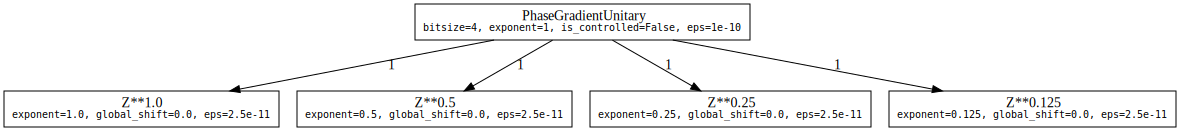

#### Counts totals:
 - `Z**0.125`: 1
 - `Z**0.25`: 1
 - `Z**0.5`: 1
 - `Z**1.0`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
phase_gradient_unitary_g, phase_gradient_unitary_sigma = phase_gradient_unitary.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(phase_gradient_unitary_g)
show_counts_sigma(phase_gradient_unitary_sigma)

## `PhaseGradientState`
Prepare a phase gradient state $|\phi\rangle$ on a new register of bitsize $b_{grad}$

$$
    |\phi\rangle = \frac{1}{\sqrt{2^{n}}} \sum_{k=0}^{2^{n} - 1} \omega_{n, t}^{k} |k\rangle
$$

where

$$
    \omega_{n, t} = \exp\left(\frac{2\pi i t}{2^n}\right)
$$

Allocates / deallocates registers to store the phase gradient state and delegates
to the `PhaseGradientUnitary` bloq defined above.

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix A: Addition for controlled rotations


In [7]:
from qualtran.bloqs.rotations import PhaseGradientState

### Example Instances

In [8]:
from qualtran import QFxp

phase_gradient_state = PhaseGradientState(4)

#### Graphical Signature

In [9]:
from qualtran.drawing import show_bloqs
show_bloqs([phase_gradient_state],
           ['`phase_gradient_state`'])

### Call Graph

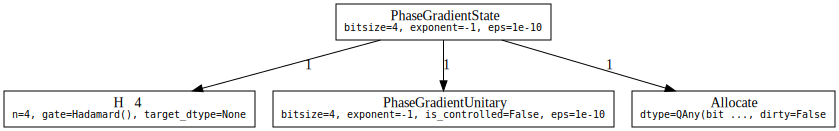

#### Counts totals:
 - `Allocate`: 1
 - `H⨂4`: 1
 - `PhaseGradientUnitary`: 1

In [10]:
from qualtran.resource_counting.generalizers import ignore_split_join
phase_gradient_state_g, phase_gradient_state_sigma = phase_gradient_state.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(phase_gradient_state_g)
show_counts_sigma(phase_gradient_state_sigma)

## `AddIntoPhaseGrad`
Quantum-quantum addition into a phase gradient register using $b_{phase} - 2$ Toffolis

$$
    U|x\rangle|\text{phase\_grad}\rangle = |x\rangle|\text{phase\_grad} + x\rangle
$$

#### Parameters
 - `x_bitsize`: Size of input register.
 - `phase_bitsize`: Size of phase gradient register to which the input value should be added.
 - `right_shift`: An integer specifying the amount by which the input register x should be right shifted before adding to the phase gradient register.
 - `sign`: Whether the input register x should be  added or subtracted from the phase gradient register.
 - `controlled_by`: Whether to control this bloq with a ctrl register. When controlled_by=None, this bloq is not controlled. When controlled_by=0, this bloq is active when the ctrl register is 0. When controlled_by=1, this bloq is active when the ctrl register is 1. 

#### Registers
 - `- ctrl`: Control THRU register
 - `- x`: Input THRU register storing input value x to be added to the phase gradient register.
 - `- phase_grad`: Phase gradient THRU register. 

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix A: Addition for controlled rotations


In [11]:
from qualtran.bloqs.rotations import AddIntoPhaseGrad

### Example Instances

In [12]:
add_into_phase_grad = AddIntoPhaseGrad(4, 4)

#### Graphical Signature

In [13]:
from qualtran.drawing import show_bloqs
show_bloqs([add_into_phase_grad],
           ['`add_into_phase_grad`'])

### Call Graph

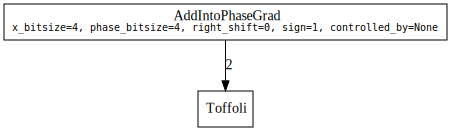

#### Counts totals:
 - `Toffoli`: 2

In [14]:
from qualtran.resource_counting.generalizers import ignore_split_join
add_into_phase_grad_g, add_into_phase_grad_sigma = add_into_phase_grad.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(add_into_phase_grad_g)
show_counts_sigma(add_into_phase_grad_sigma)

## `AddScaledValIntoPhaseReg`
Optimized quantum-quantum addition into a phase gradient register scaled by a constant $\gamma$.

$$
    U(\gamma)|x\rangle|\text{phase_grad}\rangle = |x\rangle|\text{phase_grad} + x * \gamma\rangle
$$

The operation calls `AddIntoPhaseGrad` gate $(\text{gamma_bitsize} + 2) / 2$ times.

#### Parameters
 - `x_dtype`: Fixed point specification of the input register.
 - `phase_bitsize`: Size of phase gradient register to which the scaled input should be added.
 - `gamma`: Floating point scaling factor.
 - `gamma_dtype`: `QFxp` data type capturing number of bits of precisions to be used for integer and fractional part of `gamma`. 

#### Registers
 - `x`: Input THRU register storing input value x to be scaled and added to the phase gradient register.
 - `phase_grad`: Phase gradient THRU register. 

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix A: Addition for controlled rotations


In [15]:
from qualtran.bloqs.rotations import AddScaledValIntoPhaseReg

### Example Instances

In [16]:
add_scaled_val_into_phase_reg = AddScaledValIntoPhaseReg(
    QFxp(2, 2), phase_bitsize=2, gamma=2, gamma_dtype=QFxp(2, 2)
)

#### Graphical Signature

In [17]:
from qualtran.drawing import show_bloqs
show_bloqs([add_scaled_val_into_phase_reg],
           ['`add_scaled_val_into_phase_reg`'])

### Call Graph

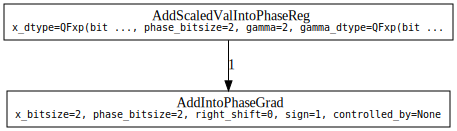

#### Counts totals:
 - `AddIntoPhaseGrad`: 1

In [18]:
from qualtran.resource_counting.generalizers import ignore_split_join
add_scaled_val_into_phase_reg_g, add_scaled_val_into_phase_reg_sigma = add_scaled_val_into_phase_reg.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(add_scaled_val_into_phase_reg_g)
show_counts_sigma(add_scaled_val_into_phase_reg_sigma)